In [2]:
%load_ext autoreload
%autoreload 2

In [80]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
from datasets import MNIST_rot
from train_vit import VisionTransformer
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(embed_dim=64,
                        hidden_dim=512,
                        num_heads=4,
                        num_layers=6,
                        patch_size=4,
                        num_channels=1,
                        num_patches=49,
                        num_classes=10,
                        dropout=0.1).to(device)
model_path = "saved/results/non_equivariant_vit.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

<All keys matched successfully>

In [5]:
data_mean = (0.1307,)
data_stddev = (0.3081,)
transform_test = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(data_mean, data_stddev),
    ]
)
test_set = MNIST_rot(root="../data", stage="test", download=True, transform=transform_test, data_fraction=1, only_3_and_8=True)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

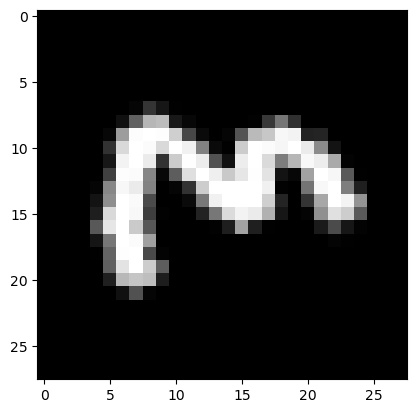

In [6]:
data = iter(test_loader)
image, target = next(data)
plt.imshow(image.squeeze(), cmap="gray")

In [41]:
def get_transforms(image, n_rotations=4, flips=True):
    """
    Returns all transformations of the input image.
    """
    transforms = [image]

    # Rotations
    for i in range(1, n_rotations):
        angle = i * (360 / n_rotations)
        rotated_image = TF.rotate(image, angle)
        transforms.append(rotated_image)

    # Flips
    if flips:
        flips = []
        for transform in transforms:
            flipped_image_lr = TF.hflip(transform)
            flips.append(flipped_image_lr)
        # for transform in transforms:
        #     flipped_image_ud = TF.vflip(transform)
        #     flips.append(flipped_image_ud)
        transforms.extend(flips)
        
    return torch.cat(transforms)

def visualize_transforms(transformed_images):
    num_images = len(transformed_images)
    num_rows = (num_images - 1) // 4 + 1
    fig, axes = plt.subplots(num_rows, 4, figsize=(16, 4*num_rows))

    for i, img in enumerate(transformed_images):
        row = i // 4
        col = i % 4
        axes[row, col].imshow(img.permute(1, 2, 0), cmap="gray")  # Permute dimensions for visualization
        axes[row, col].axis('off')

    # Hide empty subplots
    for i in range(num_images, num_rows * 4):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')

    # Labeling axes
    for ax, col in zip(axes[0], ['Original', '90°', '180°', '270°']):
        ax.set_title(col, size="larger")

    plt.tight_layout()
    plt.show()

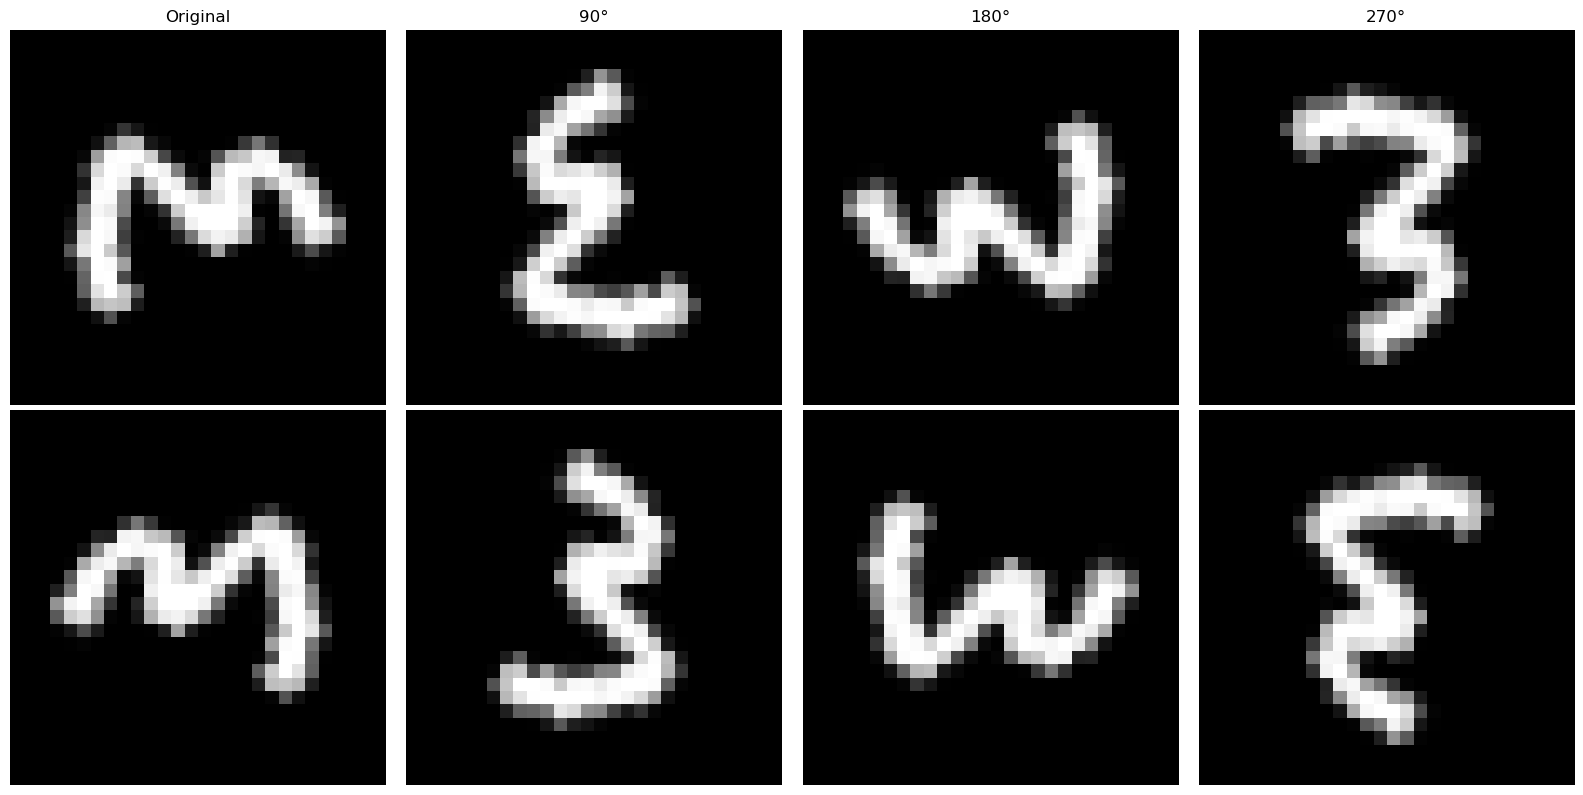

In [42]:
transformed_images = get_transforms(image)
visualize_transforms(transformed_images)

In [40]:
model.forward(image, output_cls=True).shape

torch.Size([1, 64])

In [45]:
model.forward(get_transforms(image), output_cls=True).shape

torch.Size([8, 64])

#### Some possibilities of equivariant combination of the latent representations:
- Mean pooling
- Max pooling
- Sum
- Most probable
- Highest probability among transformations
- Learn weights for weighted average

NOTE: don't forget to freeze earlier layers and to do model.eval() during inference as dropout is used in the model

#### Mean pooling

In [47]:
model.forward(get_transforms(image), output_cls=True).mean(dim=0, keepdim=True).shape

torch.Size([1, 64])

#### Max pooling

In [53]:
torch.max(model.forward(get_transforms(image), output_cls=True), dim=0, keepdim=True).values.shape

torch.Size([1, 64])

#### Sum

In [54]:
model.forward(get_transforms(image), output_cls=True).sum(dim=0, keepdim=True).shape

torch.Size([1, 64])

#### Most probable

In [62]:
torch.prod(torch.softmax(model.forward(get_transforms(image)), dim=1), dim=0)
# TODO: what will the loss function be??
# does cross entropy still make sense??

tensor([9.4150e-15, 1.7482e-13, 5.6348e-09, 5.8640e-09, 9.9647e-07, 2.9065e-09,
        1.9207e-08, 5.5198e-07, 1.4352e-09, 2.2435e-07],
       grad_fn=<ProdBackward1>)

#### Most certain among transformations

In [78]:
a=torch.softmax(model.forward(get_transforms(image)), dim=1)
max_index = torch.argmax(a)
max_row = max_index // a.shape[1]
a[max_row, :], a, max_index, max_row

# No learning just selecting

(tensor([0.0116, 0.0335, 0.0653, 0.0788, 0.1978, 0.0729, 0.0957, 0.2149, 0.0726,
         0.1569], grad_fn=<SliceBackward0>),
 tensor([[0.0148, 0.0330, 0.0946, 0.0838, 0.1674, 0.0803, 0.1200, 0.1848, 0.0691,
          0.1521],
         [0.0157, 0.0296, 0.0929, 0.0993, 0.1922, 0.0898, 0.1108, 0.1473, 0.0686,
          0.1540],
         [0.0116, 0.0335, 0.0653, 0.0788, 0.1978, 0.0729, 0.0957, 0.2149, 0.0726,
          0.1569],
         [0.0268, 0.0160, 0.1064, 0.1121, 0.1636, 0.1006, 0.1055, 0.1327, 0.0922,
          0.1442],
         [0.0138, 0.0245, 0.0990, 0.0839, 0.1580, 0.0770, 0.1105, 0.1927, 0.0770,
          0.1636],
         [0.0223, 0.0217, 0.1130, 0.0941, 0.1484, 0.0864, 0.1175, 0.1647, 0.0860,
          0.1459],
         [0.0206, 0.0201, 0.0883, 0.0877, 0.1722, 0.0799, 0.1071, 0.1781, 0.0926,
          0.1533],
         [0.0285, 0.0144, 0.1112, 0.1089, 0.1776, 0.0932, 0.1167, 0.1269, 0.0958,
          0.1269]], grad_fn=<SoftmaxBackward0>),
 tensor(27),
 tensor(2))

#### Learn weighs for weighted average

Also here there are a couple of options.
- a) nn takes as input entire latent dimension and outputs scalar representing weight for that dimensions
- b) nn takes as input the i'th entry of each latent dimension, the concatenation is a new latent dimension. Now we have to satisfy equivariance so this order of input should not matter. Use a transformer without PE in this case is a solution.


In [101]:
# a)
class Project(nn.Module):
    def __init__(self, n_dim=64):
        super().__init__()
        self.fc = nn.Linear(n_dim, 1)  # probably something more intricate here

    def forward(self, x):
        x = self.fc(x)
        x = torch.softmax(x, dim=0)  # convert to weights
        return x

project = Project()
old_latent_dims = model.forward(get_transforms(image), output_cls=True)
weights = project(old_latent_dims)
new_latent_dims = weights*old_latent_dims
new_latent_dim = new_latent_dims.sum(dim=0)
new_latent_dim.shape  # still need to project this later

torch.Size([64])

In [102]:
# b)
class Project(nn.Module):
    def __init__(self, n_transforms=8):
        super().__init__()
        self.fc = nn.Linear(n_transforms, 1)  # TODO this should become a transformer

    def forward(self, x):
        x = self.fc(x)
        x = torch.softmax(x, dim=0)  # convert to weights
        return x

# just some standard stuff
# for now first make the above work
# this is by far the most interesting approach